In [134]:
import numpy as np
import cv2
import mediapipe as mp 
import matplotlib.pyplot as plt 


## Globals


In [135]:
video_path = "IMG_1810.MOV"

# Hand detection model initialization
mp_hands = mp.solutions.hands

hands = mp_hands.Hands(
    max_num_hands = 2,
    min_detection_confidence = 0.7,
    min_tracking_confidence = 0.5,
)

I0000 00:00:1729008417.738237 2105942 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro


In [136]:
def calc_bounding_box(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0,2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis = 0)

    x,y,w,h = cv2.boundingRect(landmark_array)
    
    return [x,y,w,h]

W0000 00:00:1729008417.747958 2132551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729008417.751957 2132551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Extracting First Frame

In [137]:

vcap_first_frame = cv2.VideoCapture(video_path)
roi = None
while (True):
  print("iteration")
  ret, frame = vcap_first_frame.read()

  if not ret:
    break

  frame = cv2.resize(frame,(0,0), fx=0.3, fy=0.3)
  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  results = hands.process(image)
  if results.multi_hand_landmarks and roi is None:
    for hand_landmarks in results.multi_hand_landmarks:
      # Assigning bounding box
      brect = calc_bounding_box(image, hand_landmarks) 
      roi = frame[brect[1]:brect[1]+brect[3], brect[0]:brect[0]+brect[2]]
  break  

iteration


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


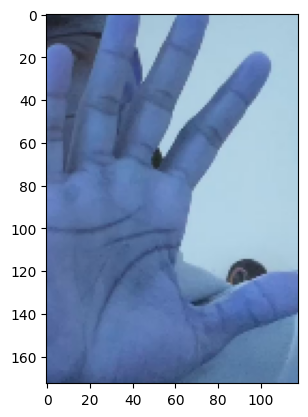

In [138]:
plt.imshow(roi)

In [139]:
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv_roi, np.array((0., 10., 37.)), np.array((180., 200., 240.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0,100])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

term_crit = (cv2.TermCriteria_EPS | cv2.TermCriteria_COUNT, 25, 3)

In [140]:
min_hsv = np.min(hsv_roi, axis=(0, 1))  # Minimum HSV values
max_hsv = np.max(hsv_roi, axis=(0, 1)) 

print(min_hsv)
print(max_hsv)

[ 0 10 37]
[179 194 238]


## MeanShift Algorithm

In [141]:
vcap = cv2.VideoCapture(video_path)
frames = []
while True:
    ret, frame = vcap.read()
    
    if not ret:
        break
    
    frame = cv2.resize(frame,(0,0), fx=0.3, fy=0.3)
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    frames.append(image)
    back_proj = cv2.calcBackProject([image], [0], roi_hist, [0,100], 1)
    ret, brect = cv2.meanShift(back_proj, brect, term_crit)
    out = cv2.rectangle(frame, (brect[0], brect[1]), (brect[0]+brect[2], brect[1]+brect[3]), 255, 2)
    
    cv2.imshow('tracker',out)
    
    k = cv2.waitKey(1) & 0xff
    if k == ord('q'):
        break

vcap.release()
cv2.waitKey(10)
cv2.destroyAllWindows()
cv2.waitKey(10)

-1

In [142]:
output = []

for frame in frames:
    back_proj = cv2.calcBackProject([frame], [0], roi_hist, [0,100], 1)
    
    ret, brect = cv2.meanShift(back_proj, brect, term_crit)
    out = cv2.rectangle(frame, (brect[0], brect[1]), (brect[0]+brect[2], brect[1]+brect[3]), 255, 2)
    output.append(out)

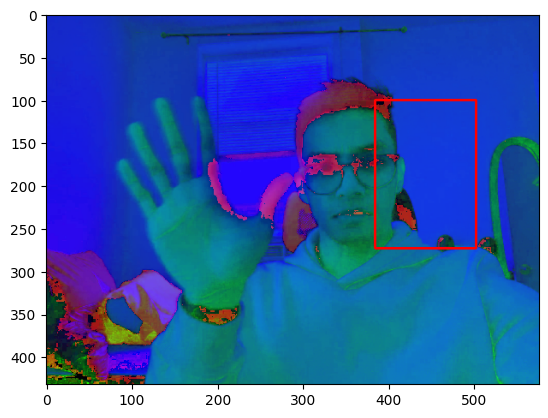

In [149]:
plt.imshow(output[50])

## CAMShift Algorithm

In [85]:
vcap = cv2.VideoCapture(video_path)
frames = []
while True:
    ret, frame = vcap.read()
    
    if not ret:
        break
    
    frame = cv2.resize(frame,(0,0), fx=0.3, fy=0.3)
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    frames.append(image)
    back_proj = cv2.calcBackProject([frame], [0], roi_hist, [0,100], 1)
    ret, brect = cv2.CamShift(back_proj, brect, term_crit)
    out = cv2.rectangle(frame, (brect[0], brect[1]), (brect[0]+brect[2], brect[1]+brect[3]), 255, 2)
    
    cv2.imshow('tracker',out)
    
    k = cv2.waitKey(1) & 0xff
    if k == ord('q'):
        break

vcap.release()
cv2.waitKey(10)
cv2.destroyAllWindows()
cv2.waitKey(10)

-1

In [81]:
output = []

for frame in frames:
    back_proj = cv2.calcBackProject([frame], [0], roi_hist, [0,100], 1)
    
    ret, brect = cv2.meanShift(back_proj, brect, term_crit)
    out = cv2.rectangle(frame, (brect[0], brect[1]), (brect[0]+brect[2], brect[1]+brect[3]), 255, 2)
    output.append(out)

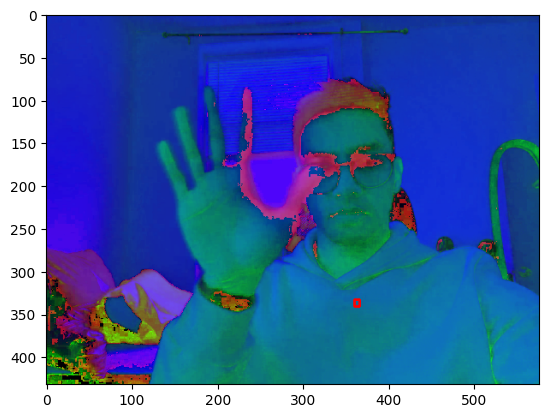

In [83]:
plt.imshow(output[30])